In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import numpy as np
import networkx as nx
import itertools

from dgl.nn.pytorch import GraphConv

In [ ]:
import matplotlib.animation as anim
import matplotlib.pyplot as plt

from IPython.display import HTML

In [2]:
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [3]:
G = build_karate_club_graph()
print("We have {} nodes.".format(G.number_of_nodes()))
print("We have {} edges.".format(G.number_of_edges()))

We have 34 nodes.
We have 156 edges.


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


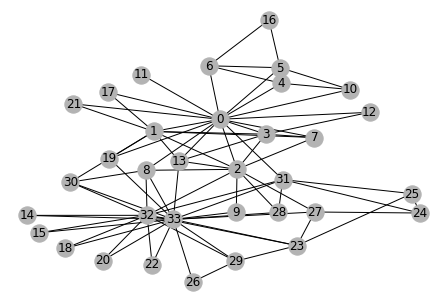

In [4]:
nx_G = G.to_networkx().to_undirected()

pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Assign features to nodes and edges

In [6]:
embed = nn.Embedding(34, 5)
G.ndata['feat'] = embed.weight

In [8]:
# input features for node 2
print(G.ndata['feat'][2])

# input features for nodes 10 and 11
print(G.ndata['feat'][[10, 11]])


tensor([ 0.1528, -0.8311,  1.0925,  0.5865,  1.3306], grad_fn=<SelectBackward>)
tensor([[-0.1560,  0.0637, -1.9700,  0.2725, -0.9171],
        [-0.5245, -0.3708, -1.5438, -0.1226, -0.2503]],
       grad_fn=<IndexBackward>)


## Define the neural network

In [10]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
        
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

In [11]:
net = GCN(5, 5, 2)

## Data preparation and initialization

In [12]:
# we only have two labels; we want to learn embeddings that will increase
# the classification accuracy on these.

inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

## Training

In [13]:
optim = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []

for epoch in range(50):
    logits = net(G, inputs)
    
    # for visualization
    all_logits.append(logits.detach())
    
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print(f'Epoch {epoch:2d}: Loss: {loss.item():.4f}')

Epoch  0: Loss: 0.6864
Epoch  1: Loss: 0.6575
Epoch  2: Loss: 0.6320
Epoch  3: Loss: 0.6093
Epoch  4: Loss: 0.5884
Epoch  5: Loss: 0.5697
Epoch  6: Loss: 0.5515
Epoch  7: Loss: 0.5337
Epoch  8: Loss: 0.5161
Epoch  9: Loss: 0.4988
Epoch 10: Loss: 0.4814
Epoch 11: Loss: 0.4639
Epoch 12: Loss: 0.4459
Epoch 13: Loss: 0.4263
Epoch 14: Loss: 0.4066
Epoch 15: Loss: 0.3868
Epoch 16: Loss: 0.3665
Epoch 17: Loss: 0.3453
Epoch 18: Loss: 0.3239
Epoch 19: Loss: 0.3023
Epoch 20: Loss: 0.2808
Epoch 21: Loss: 0.2597
Epoch 22: Loss: 0.2389
Epoch 23: Loss: 0.2186
Epoch 24: Loss: 0.1991
Epoch 25: Loss: 0.1806
Epoch 26: Loss: 0.1629
Epoch 27: Loss: 0.1462
Epoch 28: Loss: 0.1307
Epoch 29: Loss: 0.1165
Epoch 30: Loss: 0.1034
Epoch 31: Loss: 0.0915
Epoch 32: Loss: 0.0805
Epoch 33: Loss: 0.0708
Epoch 34: Loss: 0.0621
Epoch 35: Loss: 0.0545
Epoch 36: Loss: 0.0478
Epoch 37: Loss: 0.0419
Epoch 38: Loss: 0.0367
Epoch 39: Loss: 0.0322
Epoch 40: Loss: 0.0283
Epoch 41: Loss: 0.0249
Epoch 42: Loss: 0.0219
Epoch 43: L

## Visualization

In [15]:
def draw(i):
    colormap = ['#00ffff', '#ff00ff']
    
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls_ = pos[v].argmax()
        
        colors.append(colormap[cls_])
    
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Epoch: {i}')
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
                     with_labels=True, node_size=300, ax=ax)

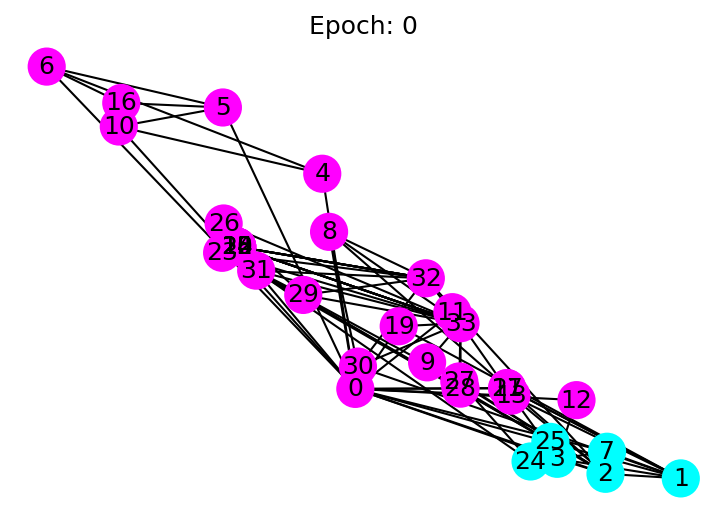

In [16]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)

In [17]:
ani = anim.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [23]:
HTML(ani.to_html5_video())